## 1. Outline 

1. Load the dataset and visualise
2. add batchnorm layers
3. Comparison with and without batch normalization layers
4. Add Dropout layer
5. Comparison with and without dropout layers

In [87]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torchvision.models as models
from tqdm import tqdm_notebook
from PIL import Image

!pip install google_images_download
import os, shutil, sys
from google_images_download import google_images_download

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device                

device(type='cuda', index=0)

## 2. Dataset and visualization

In [88]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())
batch_size = 256
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
classes = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

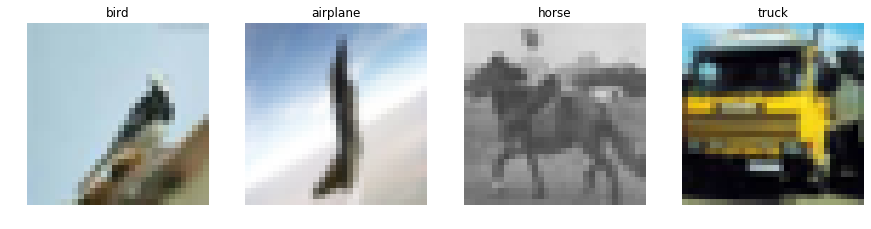

In [90]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

def show_batch_images(dataloader, no_images=4):
  images,labels = iter(dataloader).next()
  plt.figure(figsize=(15,10))
  
  for i, (img,label) in enumerate(zip(images[0:no_images],labels[0:no_images])):
    img = np.transpose(img.numpy(), (1,2,0))
    ax = plt.subplot(1,no_images,i+1)
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(classes[label.item()])
    ax.axis('off')
 
  plt.show()
  
show_batch_images(trainloader)

In [0]:
def return_accuracy(data_loader,model):
  correct = 0
  total = 0
  model.eval()
  for images,labels in data_loader:
    images,labels = images.to(device), labels.to(device)
    total += len(images)
    correct += torch.sum(torch.argmax(model(images),dim=1)==labels).item()
  return correct/total*100

More on improving the model:

https://stats.stackexchange.com/questions/272607/cifar-10-cant-get-above-60-accuracy-keras-with-tensorflow-backend




## 3. Training with ResNet model

In [0]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features,len(classes))
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [0]:
import time, copy

def train_model(model, optimizer, criterion, num_epochs=10):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch,num_epochs-1))
    print('-'*10)

    running_loss = 0.0
    running_correct = 0.0
    model.train()

    for images,labels in trainloader:

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(True):
        outputs = model(images)
        preds = torch.argmax(outputs,dim=1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

      # statistics
      running_loss += loss
      running_correct += torch.sum(preds==labels.data)

    epoch_loss = running_loss/len(trainloader)
    epoch_acc =  running_correct.double()/len(trainloader)

    print('Training Loss: {:.4f} Train Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
    
    
    # Evaluation
    model.eval()
    running_test_loss = 0.0
    running_test_correct = 0.0
    for images,labels in testloader:
      images, labels = images.to(device), labels.to(device)

      with torch.set_grad_enabled(False):
        outputs = model(images)
        preds = torch.argmax(outputs,dim=1)
        loss = criterion(outputs,labels)
        
      running_test_loss += loss
      running_test_correct += torch.sum(preds==labels.data)
      
    epoch_test_loss = running_test_loss/len(testloader)
    epoch_test_acc =  running_test_correct.double()/len(testloader)

    print('Test Loss: {:.4f} Test Accuracy: {:.4f}'.format(epoch_test_loss, epoch_test_acc))

    if epoch_test_acc > best_acc:
      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = epoch_test_acc

  time_elapsed = time.time() - since
  print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed/60, time_elapsed%60))
  print('Best accuracy: {:.2f}'.format(best_acc))
  
#   model.load_state_dict(best_model_wts)
  return model


In [94]:
trained_model = train_model(model, optimizer, criterion, num_epochs = 25)

Epoch 0/24
----------
Training Loss: 1.7798 Train Accuracy: 95.9235
Test Loss: 1.4813 Test Accuracy: 118.8000
Epoch 1/24
----------
Training Loss: 1.3881 Train Accuracy: 130.3673
Test Loss: 1.7861 Test Accuracy: 110.2250
Epoch 2/24
----------
Training Loss: 1.4227 Train Accuracy: 130.9898
Test Loss: 2.6713 Test Accuracy: 89.9000
Epoch 3/24
----------
Training Loss: 1.4578 Train Accuracy: 125.1684
Test Loss: 1.2934 Test Accuracy: 134.1750
Epoch 4/24
----------
Training Loss: 1.1304 Train Accuracy: 153.4643
Test Loss: 1.2334 Test Accuracy: 140.4500
Epoch 5/24
----------


KeyboardInterrupt: ignored

In [0]:
%%time
per_class_accuracy = {}
for class_ in classes.values():
  per_class_accuracy.setdefault(class_,0)

for images,labels in testloader:
  images, labels = images.to(device), labels.to(device)
  for image, label in zip(images,labels):
    image = image[None,:,:,:] # adding one more dimension
    label = label.item()
    prediction = torch.argmax(model(image)).item()
    per_class_accuracy[classes[label]] += (int(label==prediction))
    
    break
print(per_class_accuracy)

## 4. Test with real data

In [0]:
search_queries = ['deer']  
response = google_images_download.googleimagesdownload()  
img_format = 'jpg'
def downloadimages(query,total_images_per_class = 1): 
    arguments = {"keywords": query, 
                 "format": img_format, 
                 "limit":total_images_per_class, 
                 "print_urls":True, 
                 "size": "large"} 
    try: 
        response.download(arguments) 
      
    # Handling File NotFound Error     
    except FileNotFoundError:  
        arguments = {"keywords": query, 
                     "format": "jpg", 
                     "limit":total_images_per_class, 
                     "print_urls":True,  
                     "size": "large"} 
                       
        # Providing arguments for the searched query 
        try: 
            # Downloading the photos based 
            # on the given arguments 
            response.download(arguments)  
        except: 
            pass
          
directory = '/content/downloads'
if os.path.isdir(directory):
  shutil.rmtree(directory)
  print(directory,'removed')
else:
  print("Directory doesnot exist")

# Driver Code 
for query in search_queries: 
  downloadimages(query)  

In [0]:
all_images_input = []
for root,dir_name,images in os.walk('/content/downloads'):
  for img in images:
    if img.endswith('.'+img_format):
      img_data = Image.open(root+os.sep+img)
      all_images_input.append(img_data)

In [0]:
tr = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])
output = [(tr(x),x) for x in all_images_input]

In [0]:
img_data, image = output[0]
prediction = model(img_data[None,:,:,:].to(device))
label = classes[torch.argmax(prediction).data.item()]

plt.imshow(image)
plt.title('Prediction: '+label)
plt.axis('off')
plt.show()